In [1]:
import cv2
import numpy as np


In [2]:
import imutils
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev


In [3]:
def get_perp_bisector(line):
    (x1, y1), (x2, y2) = line
    cx = (x1+x2)/2;
    cy = (y1+y2)/2;

    x1-=cx; y1-=cy;
    x2-=cx; y2-=cy;

    xtemp = x1; ytemp = y1;
    x1=-ytemp; y1=xtemp; 

    xtemp = x2; ytemp = y2;
    x2=-ytemp; y2=xtemp; 

    x1+=cx; y1+=cy;
    x2+=cx; y2+=cy;
    
    return ((int(x1), int(y1)), (int(x2), int(y2)))

In [4]:
def get_md_pt(line, contours, image):
    perp1 = get_perp_bisector(line)
    img_blk_ln = np.zeros(image.shape).astype(image.dtype)
    cv2.line(img_blk_ln, perp1[0], perp1[1], (255,255,255), thickness=1, lineType=8, shift=0)
    img_blk_cnt = np.zeros(image.shape).astype(image.dtype)
    cv2.drawContours(img_blk_cnt, contours, 0, (255,255, 255), 1)
    img_blk = np.zeros(image.shape).astype(image.dtype)
    cv2.bitwise_and(img_blk_cnt, img_blk_ln, img_blk)
#     cv2.line(image, line[0], line[1], (255, 0, 0), thickness=1, lineType=8, shift=0)
    pixelpoints = np.transpose(np.nonzero(img_blk))
#     plt.imshow(img_blk)
    return (pixelpoints[0][0], pixelpoints[0][1])
    

In [5]:
def smooth_contours(contours):
    smoothened = []
    for contour in contours:
        x,y = contour.T
        # Convert from numpy arrays to normal arrays
        x = x.tolist()[0]
        y = y.tolist()[0]
        # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.splprep.html
        tck, u = splprep([x,y], u=None, s=1.0, per=1)
        # https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.linspace.html
        u_new = np.linspace(u.min(), u.max(), 25)
        # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.splev.html
        x_new, y_new = splev(u_new, tck, der=0)
        # Convert it back to numpy format for opencv to be able to display it
        res_array = [[[int(i[0]), int(i[1])]] for i in zip(x_new,y_new)]
        smoothened.append(np.asarray(res_array, dtype=np.int32))
    return smoothened

In [6]:
def warp_image(image, contours):
    rect = cv2.minAreaRect(contours[0])

    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    width = int(rect[1][0])
    height = int(rect[1][1])
    box = np.int0(box)

    W = rect[1][0]
    H = rect[1][1]

    Xs = [i[0] for i in box]
    Ys = [i[1] for i in box]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)

    angle = rect[2]
    if angle < -45:
        angle += 90

    center = ((x1+x2)/2,(y1+y2)/2)
    # Size of the upright rectangle bounding the rotated rectangle
    size = (x2-x1, y2-y1)
    M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)
    # Cropped upright rectangle
    cropped = cv2.getRectSubPix(image, size, center)
    cropped = cv2.warpAffine(cropped, M, size)
    croppedW = H if H > W else W
    croppedH = H if H < W else W
    # Final cropped & rotated rectangle
    return cv2.getRectSubPix(cropped, (int(croppedW),int(croppedH)), (size[0]/2, size[1]/2))

In [7]:
def find_pts(path):
    image = cv2.imread(path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)
    # plt.imshow(thresh, cmap="gray")
    old_contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    old_contours = imutils.grab_contours(old_contours)
    # smooth contours 
    contours = smooth_contours(old_contours)

    
    image = np.zeros(image.shape).astype(image.dtype)
    cv2.fillPoly(image, contours, [255,255,255])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    # Extract corners
    corners = cv2.goodFeaturesToTrack(gray, 4, 0.01, 20)
    corners = np.int0(corners)
    true_corners = []
    # get corners closest to contour
    for pt in corners:
        true_corners.append(min([(x, np.linalg.norm(x-pt)) for x in contours[0]], key = lambda t: t[1])[0].tolist()[0])
    # draw circle around points
    for pt in true_corners:
        (x, y) = pt
        cv2.circle(image, (x,y), 1, (255,0,0), thickness=1, lineType=8, shift=0)
    # draw lines for the corner pts
    sorted_pts = sorted(true_corners, key=lambda x: x[1])
    line1 = (tuple(sorted_pts[0]), tuple(sorted_pts[1]))
    line2 = (tuple(sorted_pts[2]), tuple(sorted_pts[3]))
    cv2.line(image, line1[0], line2[0], (255,0,0), thickness=1, lineType=8, shift=0)
    cv2.line(image, line1[1], line2[1], (255,0,0), thickness=1, lineType=8, shift=0)
    hms_y, hms_x = get_md_pt(line1, contours, image)
    hmi_y, hmi_x = get_md_pt(line2, contours, image)
    cv2.line(image, (hms_x, hms_y), (hmi_x, hmi_y), (255,0,0), thickness=1, lineType=8, shift=0)
    
    cv2.circle(image, (hms_x, hms_y), 1, (0,255,0), thickness=1, lineType=8, shift=0)
    cv2.circle(image, (hmi_x, hmi_y ), 1, (0,255,0), thickness=1, lineType=8, shift=0)
    
    # warp image
    
    croppedRotated = warp_image(image, old_contours)
    plt.imshow(croppedRotated)
    cv2.imwrite('keypts/{}'.format(path.split('/')[1]), croppedRotated)


failed on MR_0533_L_3.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][74]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][61]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][95]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][54]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][83]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][88]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][41]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitp

failed on MR_0785_L_6.png
failed on MR_2365_L_1.png
failed on MR_0505_L_1.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][49]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][72]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][68]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][53]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][34]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][63]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][86]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitp

failed on MR_1616_L_5.png
failed on MR_1472_L_3.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][38]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][55]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][29]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][69]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][79]=x[0][0]
  (i, m, i)))


failed on MR_1065_L_7.png
failed on MR_0999_L_3.png
failed on MR_1908_L_6.png
failed on MR_1081_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][70]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][51]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][93]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][50]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][90]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][47]=x[0][0]
  (i, m, i)))


failed on MR_1748_L_7.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][89]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][97]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][97]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][39]=x[0][0]
  (i, m, i)))


failed on MR_1237_L_3.png
failed on MR_1334_L_0.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][62]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][91]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][103]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][42]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][73]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][82]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][106]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fi

failed on MR_1705_L_6.png
failed on MR_1176_L_4.png
failed on MR_1585_L_1.png
failed on MR_1699_L_7.png
failed on MR_1166_L_4.png
failed on MR_1192_L_5.png
failed on MR_1895_L_2.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][68]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][115]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][57]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][121]=x[0][0]
  (i, m, i)))


failed on MR_0696_L_5.png
failed on MR_2282_L_3.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][87]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][99]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][102]=x[0][0]
  (i, m, i)))


failed on MR_0686_L_5.png
failed on MR_0558_L_0.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][76]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][84]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][105]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][92]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][59]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][136]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][125]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_f

failed on MR_1857_L_1.png
failed on MR_1643_L_2.png
failed on MR_1427_L_4.png
failed on MR_0626_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][78]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][30]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][60]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][52]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][117]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][46]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][24]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fit

failed on MR_1681_L_1.png
failed on MR_0063_L_6.png
failed on MR_0768_L_4.png
failed on MR_0566_L_4.png
failed on MR_2162_L_2.png
failed on MR_0990_L_0.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][94]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][43]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][26]=x[0][0]
  (i, m, i)))


failed on MR_0827_L_8.png
failed on MR_1132_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][127]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][27]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][98]=x[0][0]
  (i, m, i)))


failed on MR_1525_L_2.png
failed on MR_2248_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][80]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][48]=x[0][0]
  (i, m, i)))


failed on MR_0453_L_5.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][77]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][76]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][111]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][110]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][110]=x[1][0]
  (i, m, i)))


failed on MR_0601_L_1.png
failed on MR_2119_L_1.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][101]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][64]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][116]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][71]=x[1][0]
  (i, m, i)))


failed on MR_1782_L_2.png
failed on MR_1105_L_1.png
failed on MR_1750_L_1.png
failed on MR_0953_L_6.png
failed on MR_1357_L_5.png
failed on MR_0943_L_6.png
failed on MR_1357_L_4.png
failed on MR_2155_L_4.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][74]=x[1][0]
  (i, m, i)))


failed on MR_1534_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][61]=x[1][0]
  (i, m, i)))


failed on MR_2254_L_9.png
failed on MR_0975_L_5.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][112]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][28]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][77]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][126]=x[0][0]
  (i, m, i)))


failed on MR_1219_L_6.png
failed on MR_1395_L_7.png
failed on MR_0601_L_0.png
failed on MR_0453_L_4.png
failed on MR_0428_L_7.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][58]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][81]=x[0][0]
  (i, m, i)))


failed on MR_0827_L_9.png
failed on MR_0566_L_5.png
failed on MR_0882_L_7.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][75]=x[0][0]
  (i, m, i)))


failed on MR_2118_L_5.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][105]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][82]=x[1][0]
  (i, m, i)))


failed on MR_1368_L_5.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][119]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][36]=x[0][0]
  (i, m, i)))


failed on MR_1963_L_4.png
failed on MR_2078_L_3.png
failed on MR_1334_L_1.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][66]=x[1][0]
  (i, m, i)))


failed on MR_0655_L_2.png
failed on MR_1065_L_6.png
failed on MR_2365_L_0.png
failed on MR_1996_L_0.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][73]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][50]=x[1][0]
  (i, m, i)))


failed on MR_0785_L_7.png
failed on MR_0917_L_5.png
failed on MR_0499_L_1.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][140]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][67]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][37]=x[1][0]
  (i, m, i)))


failed on MR_0533_L_2.png
failed on MR_0533_L_0.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][60]=x[1][0]
  (i, m, i)))


failed on MR_0917_L_7.png
failed on MR_1894_L_4.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][63]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][129]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][133]=x[0][0]
  (i, m, i)))


failed on MR_1908_L_5.png
failed on MR_1616_L_6.png
failed on MR_1884_L_4.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][139]=x[0][0]
  (i, m, i)))


failed on MR_2035_L_0.png
failed on MR_1723_L_7.png
failed on MR_1166_L_7.png
failed on MR_1192_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][65]=x[1][0]
  (i, m, i)))


failed on MR_2110_L_1.png
failed on MR_1973_L_6.png
failed on MR_1909_L_0.png
failed on MR_1378_L_7.png
failed on MR_1127_L_8.png
failed on MR_0662_L_7.png
failed on MR_1631_L_1.png
failed on MR_2250_L_3.png
failed on MR_0548_L_3.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][35]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][87]=x[1][0]
  (i, m, i)))


failed on MR_0822_L_6.png
failed on MR_1437_L_7.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][107]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][83]=x[1][0]
  (i, m, i)))


failed on MR_1394_L_0.png
failed on MR_1911_L_6.png
failed on MR_0566_L_7.png
failed on MR_2196_L_0.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][64]=x[1][0]
  (i, m, i)))


failed on MR_1122_L_5.png
failed on MR_0453_L_6.png
failed on MR_0086_L_1.png
failed on MR_1297_L_3.png
failed on MR_0991_L_6.png
failed on MR_0583_L_3.png
failed on MR_0943_L_5.png
failed on MR_0725_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][31]=x[0][0]
  (i, m, i)))


failed on MR_0551_L_1.png
failed on MR_1347_L_7.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][36]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][113]=x[0][0]
  (i, m, i)))


failed on MR_2109_L_3.png
failed on MR_1680_L_6.png
failed on MR_0481_L_4.png
failed on MR_1652_L_5.png
failed on MR_2233_L_7.png
failed on MR_1245_L_1.png
failed on MR_1642_L_5.png
failed on MR_1629_L_6.png
failed on MR_2248_L_4.png
failed on MR_0566_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][84]=x[1][0]
  (i, m, i)))


failed on MR_2172_L_0.png
failed on MR_1828_L_8.png
failed on MR_1681_L_3.png
failed on MR_2070_L_6.png
failed on MR_0610_L_6.png
failed on MR_1148_L_2.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][124]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][114]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][20]=x[0][0]
  (i, m, i)))


failed on MR_1042_L_2.png
failed on MR_2002_L_6.png
failed on MR_2078_L_0.png
failed on MR_1192_L_7.png
failed on MR_1973_L_7.png
failed on MR_1715_L_4.png
failed on MR_1723_L_6.png
failed on MR_1547_L_0.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][123]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][118]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][128]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][138]=x[0][0]
  (i, m, i)))


failed on MR_1856_L_6.png
failed on MR_0549_L_7.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][51]=x[1][0]
  (i, m, i)))


failed on MR_0238_L_3.png
failed on MR_0533_L_1.png
failed on MR_1546_L_5.png
failed on MR_1688_L_4.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][57]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][106]=x[1][0]
  (i, m, i)))


failed on MR_0833_L_6.png
failed on MR_0431_L_3.png
failed on MR_2267_L_1.png
failed on MR_1486_L_4.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][80]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][98]=x[1][0]
  (i, m, i)))


failed on MR_1908_L_0.png
failed on MR_1595_L_7.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][62]=x[1][0]
  (i, m, i)))


failed on MR_1631_L_4.png
failed on MR_2034_L_0.png
failed on MR_0558_L_6.png
failed on MR_1445_L_2.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][70]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][93]=x[1][0]
  (i, m, i)))


failed on MR_2002_L_2.png
failed on MR_2094_L_3.png
failed on MR_1401_L_0.png
failed on MR_1148_L_6.png
failed on MR_2099_L_8.png
failed on MR_0626_L_0.png
failed on MR_1427_L_2.png
failed on MR_2222_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][81]=x[1][0]
  (i, m, i)))


failed on MR_1356_L_6.png
failed on MR_0566_L_2.png
failed on MR_0601_L_7.png
failed on MR_0086_L_4.png
failed on MR_1680_L_2.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][120]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][34]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][89]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][86]=x[1][0]
  (i, m, i)))


failed on MR_1245_L_5.png
failed on MR_0551_L_5.png
failed on MR_0008_L_3.png
failed on MR_1910_L_6.png
failed on MR_1900_L_7.png
failed on MR_1385_L_1.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][13]=x[0][0]
  (i, m, i)))


failed on MR_2331_L_4.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][88]=x[1][0]
  (i, m, i)))


failed on MR_1245_L_4.png
failed on MR_2057_L_4.png
failed on MR_1436_L_6.png
failed on MR_0893_L_4.png
failed on MR_0491_L_1.png
failed on MR_0086_L_5.png
failed on MR_2162_L_5.png
failed on MR_2196_L_4.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][125]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][21]=x[0][0]
  (i, m, i)))


failed on MR_0990_L_7.png
failed on MR_0566_L_3.png
failed on MR_1370_L_5.png
failed on MR_2172_L_5.png
failed on MR_1911_L_2.png
failed on MR_1394_L_4.png
failed on MR_1825_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][4]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][4]=x[1][0]
  (i, m, i)))


failed on MR_1665_L_7.png
failed on MR_0063_L_1.png
failed on MR_1463_L_1.png
failed on MR_1497_L_0.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][43]=x[1][0]
  (i, m, i)))


failed on MR_0548_L_7.png
failed on MR_1150_L_1.png
failed on MR_1963_L_2.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][75]=x[1][0]
  (i, m, i)))


failed on MR_1585_L_6.png
failed on MR_1870_L_1.png
failed on MR_1227_L_4.png
failed on MR_1043_L_2.png
failed on MR_0431_L_2.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][69]=x[1][0]
  (i, m, i)))


failed on MR_0533_L_4.png
failed on MR_1732_L_6.png
failed on MR_1335_L_2.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][92]=x[1][0]
  (i, m, i)))


failed on MR_2079_L_0.png
failed on MR_2353_L_6.png
failed on MR_1335_L_0.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][45]=x[1][0]
  (i, m, i)))


failed on MR_0833_L_5.png
failed on MR_1237_L_6.png
failed on MR_1715_L_3.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][59]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][39]=x[1][0]
  (i, m, i)))


failed on MR_0135_L_7.png
failed on MR_1052_L_5.png
failed on MR_0995_L_8.png
failed on MR_1607_L_5.png
failed on MR_1909_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][53]=x[1][0]
  (i, m, i)))


failed on MR_0892_L_3.png
failed on MR_1321_L_8.png
failed on MR_0600_L_1.png
failed on MR_2214_L_7.png
failed on MR_1148_L_5.png
failed on MR_2056_L_3.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][111]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][29]=x[1][0]
  (i, m, i)))


failed on MR_0566_L_1.png
failed on MR_1297_L_5.png
failed on MR_0893_L_6.png
failed on MR_2057_L_6.png
failed on MR_2047_L_6.png
failed on MR_0194_L_1.png
failed on MR_0184_L_1.png
failed on MR_0008_L_0.png
failed on MR_0541_L_7.png
failed on MR_1357_L_1.png
failed on MR_1750_L_5.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][102]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][49]=x[1][0]
  (i, m, i)))


failed on MR_0443_L_1.png
failed on MR_0637_L_7.png
failed on MR_1245_L_7.png
failed on MR_2109_L_5.png
failed on MR_0475_L_3.png
failed on MR_0566_L_0.png
failed on MR_0952_L_7.png
failed on MR_1927_L_3.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][107]=x[1][0]
  (i, m, i)))


failed on MR_0600_L_0.png
failed on MR_2094_L_1.png
failed on MR_0265_L_4.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][8]=x[0][0]
  (i, m, i)))


failed on MR_2266_L_6.png
failed on MR_2034_L_2.png
failed on MR_1631_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][148]=x[0][0]
  (i, m, i)))


failed on MR_1847_L_5.png
failed on MR_1557_L_6.png
failed on MR_2068_L_6.png
failed on MR_0770_L_6.png
failed on MR_1585_L_5.png
failed on MR_2110_L_6.png
failed on MR_1595_L_5.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][94]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][11]=x[0][0]
  (i, m, i)))


failed on MR_0572_L_8.png
failed on MR_0833_L_4.png
failed on MR_0859_L_2.png
failed on MR_2353_L_7.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][122]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][9]=x[0][0]
  (i, m, i)))


failed on MR_1433_L_8.png
failed on MR_2170_L_4.png
failed on MR_1527_L_4.png
failed on MR_0542_L_0.png
failed on MR_0528_L_6.png
failed on MR_0852_L_3.png
failed on MR_1403_L_0.png
failed on MR_1677_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][137]=x[0][0]
  (i, m, i)))


failed on MR_1373_L_1.png
failed on MR_0737_L_3.png
failed on MR_0529_L_3.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][134]=x[0][0]
  (i, m, i)))


failed on MR_0108_L_5.png
failed on MR_1199_L_0.png
failed on MR_0807_L_4.png
failed on MR_1129_L_3.png
failed on MR_1327_L_3.png
failed on MR_0531_L_5.png
failed on MR_0745_L_3.png
failed on MR_1994_L_7.png
failed on MR_0283_L_7.png
failed on MR_1623_L_4.png
failed on MR_1855_L_7.png
failed on MR_2134_L_6.png
failed on MR_0904_L_7.png
failed on MR_1985_L_2.png
failed on MR_1587_L_7.png
failed on MR_1809_L_3.png
failed on MR_0101_L_6.png
failed on MR_0914_L_6.png
failed on MR_1587_L_6.png
failed on MR_0101_L_7.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][19]=x[0][0]
  (i, m, i)))


failed on MR_0796_L_4.png
failed on MR_1310_L_5.png
failed on MR_1180_L_2.png
failed on MR_2134_L_7.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][144]=x[0][0]
  (i, m, i)))


failed on MR_1336_L_7.png
failed on MR_1855_L_6.png
failed on MR_1234_L_1.png
failed on MR_0293_L_6.png
failed on MR_2264_L_5.png
failed on MR_1605_L_7.png
failed on MR_0630_L_9.png
failed on MR_0078_L_2.png
failed on MR_1658_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][96]=x[1][0]
  (i, m, i)))


failed on MR_0949_L_7.png
failed on MR_1862_L_1.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][90]=x[1][0]
  (i, m, i)))


failed on MR_1083_L_1.png
failed on MR_2179_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][101]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][17]=x[0][0]
  (i, m, i)))


failed on MR_1271_L_6.png
failed on MR_0084_L_5.png
failed on MR_1319_L_6.png
failed on MR_0056_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][15]=x[0][0]
  (i, m, i)))


failed on MR_0258_L_6.png
failed on MR_1117_L_6.png
failed on MR_2086_L_2.png
failed on MR_1667_L_7.png
failed on MR_0528_L_7.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][72]=x[1][0]
  (i, m, i)))


failed on MR_0838_L_4.png
failed on MR_0542_L_1.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][99]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][91]=x[1][0]
  (i, m, i)))


failed on MR_1791_L_0.png
failed on MR_1479_L_7.png
failed on MR_0678_L_5.png
failed on MR_0700_L_7.png
failed on MR_1765_L_3.png
failed on MR_2156_L_5.png
failed on MR_0542_L_3.png
failed on MR_2146_L_5.png
failed on MR_1048_L_3.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][18]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][130]=x[0][0]
  (i, m, i)))


failed on MR_0528_L_5.png
failed on MR_2348_L_5.png
failed on MR_0538_L_5.png
failed on MR_0741_L_8.png
failed on MR_0085_L_2.png
failed on MR_1308_L_1.png
failed on MR_2096_L_0.png
failed on MR_1117_L_4.png
failed on MR_0941_L_3.png
failed on MR_1059_L_6.png
failed on MR_1934_L_7.png
failed on MR_1650_L_2.png
failed on MR_1728_L_2.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][47]=x[1][0]
  (i, m, i)))


failed on MR_1015_L_2.png
failed on MR_0108_L_6.png
failed on MR_1402_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][135]=x[0][0]
  (i, m, i)))


failed on MR_1604_L_0.png
failed on MR_1494_L_7.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][132]=x[0][0]
  (i, m, i)))


failed on MR_0821_L_5.png
failed on MR_1917_L_8.png
failed on MR_1290_L_8.png
failed on MR_0136_L_2.png
failed on MR_1327_L_0.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][122]=x[1][0]
  (i, m, i)))


failed on MR_0078_L_0.png
failed on MR_1092_L_6.png
failed on MR_0293_L_4.png
failed on MR_2274_L_7.png
failed on MR_1615_L_5.png
failed on MR_1082_L_6.png
failed on MR_1605_L_5.png
failed on MR_2264_L_7.png
failed on MR_0958_L_0.png
failed on MR_1721_L_1.png
failed on MR_1985_L_1.png
failed on MR_0796_L_6.png
failed on MR_0101_L_4.png
failed on MR_1721_L_0.png
failed on MR_1731_L_0.png
failed on MR_1649_L_0.png
failed on MR_2178_L_0.png
failed on MR_2290_L_7.png
failed on MR_1887_L_6.png
failed on MR_0670_L_0.png
failed on MR_1559_L_8.png
failed on MR_0078_L_1.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][85]=x[1][0]
  (i, m, i)))


failed on MR_0821_L_4.png
failed on MR_0477_L_3.png
failed on MR_0493_L_2.png
failed on MR_1666_L_1.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][104]=x[1][0]
  (i, m, i)))


failed on MR_0056_L_5.png
failed on MR_0737_L_1.png
failed on MR_0941_L_2.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][79]=x[1][0]
  (i, m, i)))


failed on MR_1355_L_1.png
failed on MR_0977_L_0.png
failed on MR_1780_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][10]=x[0][0]
  (i, m, i)))


failed on MR_2131_L_9.png
failed on MR_2096_L_1.png
failed on MR_1801_L_7.png
failed on MR_0476_L_6.png
failed on MR_0538_L_4.png
failed on MR_2230_L_4.png
failed on MR_0528_L_4.png
failed on MR_0542_L_2.png
failed on MR_0838_L_7.png
failed on MR_2008_L_6.png
failed on MR_2170_L_6.png
failed on MR_2184_L_7.png
failed on MR_1058_L_6.png
failed on MR_1925_L_7.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][100]=x[1][0]
  (i, m, i)))


failed on MR_2298_L_5.png
failed on MR_0612_L_4.png
failed on MR_1667_L_0.png
failed on MR_2096_L_5.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][95]=x[1][0]
  (i, m, i)))


failed on MR_0223_L_2.png
failed on MR_0528_L_0.png
failed on MR_0047_L_4.png
failed on MR_0941_L_6.png
failed on MR_0829_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][145]=x[0][0]
  (i, m, i)))


failed on MR_1934_L_2.png
failed on MR_2019_L_7.png
failed on MR_0711_L_7.png
failed on MR_0108_L_3.png
failed on MR_0493_L_6.png
failed on MR_0214_L_5.png
failed on MR_1676_L_5.png
failed on MR_1640_L_7.png
failed on MR_1434_L_1.png
failed on MR_0821_L_0.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][16]=x[0][0]
  (i, m, i)))


failed on MR_0807_L_2.png
failed on MR_1862_L_6.png
failed on MR_2179_L_1.png
failed on MR_2281_L_6.png
failed on MR_1872_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][42]=x[1][0]
  (i, m, i)))


failed on MR_0078_L_5.png
failed on MR_0899_L_5.png
failed on MR_2239_L_3.png
failed on MR_2125_L_5.png
failed on MR_1327_L_5.png
failed on MR_1138_L_0.png
failed on MR_0670_L_4.png
failed on MR_1082_L_3.png
failed on MR_1336_L_1.png
failed on MR_1275_L_8.png
failed on MR_1819_L_4.png
failed on MR_2290_L_2.png
failed on MR_0283_L_0.png
failed on MR_2178_L_5.png
failed on MR_1873_L_2.png
failed on MR_0670_L_5.png
failed on MR_1202_L_5.png
failed on MR_1658_L_0.png
failed on MR_0745_L_4.png
failed on MR_2113_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][158]=x[0][0]
  (i, m, i)))


failed on MR_0773_L_6.png
failed on MR_1269_L_6.png
failed on MR_2275_L_6.png
failed on MR_1862_L_7.png
failed on MR_2179_L_0.png
failed on MR_1844_L_5.png
failed on MR_0821_L_1.png
failed on MR_0529_L_4.png
failed on MR_0214_L_4.png
failed on MR_0711_L_6.png
failed on MR_0967_L_5.png
failed on MR_2019_L_6.png
failed on MR_1373_L_6.png
failed on MR_0513_L_8.png
failed on MR_1641_L_3.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][30]=x[1][0]
  (i, m, i)))


failed on MR_0528_L_1.png
failed on MR_1171_L_8.png
failed on MR_1403_L_7.png
failed on MR_1734_L_8.png
failed on MR_0880_L_7.png
failed on MR_2194_L_2.png
failed on MR_0966_L_0.png
failed on MR_0321_L_5.png
failed on MR_2146_L_3.png
failed on MR_1048_L_5.png
failed on MR_1479_L_3.png
failed on MR_1501_L_3.png
failed on MR_2298_L_6.png
failed on MR_2184_L_0.png
failed on MR_2314_L_7.png
failed on MR_1308_L_7.png
failed on MR_2096_L_6.png
failed on MR_0525_L_8.png
failed on MR_0476_L_1.png
failed on MR_1188_L_0.png
failed on MR_1413_L_5.png
failed on MR_0528_L_3.png
failed on MR_1702_L_8.png
failed on MR_1500_L_6.png
failed on MR_2073_L_2.png
failed on MR_0891_L_0.png
failed on MR_1666_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][32]=x[1][0]
  (i, m, i)))


failed on MR_0821_L_3.png
failed on MR_1129_L_6.png
failed on MR_1518_L_0.png
failed on MR_1862_L_5.png
failed on MR_1279_L_4.png
failed on MR_1984_L_2.png
failed on MR_0078_L_6.png
failed on MR_2229_L_0.png
failed on MR_0521_L_0.png
failed on MR_2026_L_5.png
failed on MR_1310_L_1.png
failed on MR_1819_L_6.png
failed on MR_0904_L_2.png
failed on MR_1555_L_0.png
failed on MR_0861_L_8.png
failed on MR_0101_L_2.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][56]=x[1][0]
  (i, m, i)))


failed on MR_1471_L_4.png
failed on MR_1212_L_6.png
failed on MR_2290_L_1.png
failed on MR_0660_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][117]=x[1][0]
  (i, m, i)))


failed on MR_2239_L_1.png
failed on MR_2103_L_5.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][113]=x[1][0]
  (i, m, i)))


failed on MR_0773_L_5.png
failed on MR_1083_L_4.png
failed on MR_1604_L_7.png
failed on MR_2275_L_5.png
failed on MR_1844_L_6.png
failed on MR_0821_L_2.png
failed on MR_0214_L_7.png
failed on MR_0084_L_0.png
failed on MR_0493_L_4.png
failed on MR_0108_L_1.png
failed on MR_2019_L_5.png
failed on MR_1742_L_3.png
failed on MR_1062_L_8.png
failed on MR_0528_L_2.png
failed on MR_0525_L_9.png
failed on MR_1413_L_4.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][161]=x[0][0]
  (i, m, i)))


failed on MR_0864_L_5.png
failed on MR_0173_L_2.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][44]=x[1][0]
  (i, m, i)))


failed on MR_0542_L_4.png
failed on MR_1791_L_8.png
failed on MR_0525_L_4.png
failed on MR_0384_L_5.png
failed on MR_0360_L_4.png
failed on MR_0513_L_6.png
failed on MR_2308_L_5.png
failed on MR_1206_L_3.png
failed on MR_1769_L_7.png
failed on MR_2318_L_5.png
failed on MR_0149_L_3.png
failed on MR_0534_L_1.png
failed on MR_1640_L_8.png
failed on MR_0910_L_6.png
failed on MR_0502_L_3.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][78]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][2]=x[0][0]
  (i, m, i)))


failed on MR_2268_L_3.png
failed on MR_2180_L_4.png
failed on MR_1785_L_0.png
failed on MR_0418_L_3.png
failed on MR_0954_L_4.png
failed on MR_0732_L_7.png
failed on MR_1849_L_0.png
failed on MR_1228_L_7.png
failed on MR_2142_L_7.png
failed on MR_1833_L_6.png
failed on MR_1431_L_3.png
failed on MR_1989_L_5.png
failed on MR_1280_L_2.png
failed on MR_2311_L_6.png
failed on MR_1916_L_7.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][149]=x[0][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][149]=x[1][0]
  (i, m, i)))


failed on MR_0861_L_5.png
failed on MR_1696_L_3.png
failed on MR_1179_L_0.png
failed on MR_1281_L_6.png
failed on MR_1756_L_7.png
failed on MR_1341_L_3.png
failed on MR_0945_L_0.png
failed on MR_2327_L_5.png
failed on MR_1274_L_2.png
failed on MR_1989_L_4.png
failed on MR_1663_L_6.png
failed on MR_1290_L_3.png
failed on MR_1421_L_2.png
failed on MR_1431_L_2.png
failed on MR_1228_L_6.png
failed on MR_2152_L_6.png
failed on MR_0996_L_6.png
failed on MR_1505_L_6.png
failed on MR_1609_L_0.png
failed on MR_0986_L_6.png
failed on MR_0115_L_6.png
failed on MR_1640_L_9.png
failed on MR_0910_L_7.png
failed on MR_0089_L_7.png
failed on MR_1332_L_6.png
failed on MR_2058_L_6.png
failed on MR_0534_L_0.png
failed on MR_2246_L_6.png
failed on MR_2294_L_5.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][54]=x[1][0]
  (i, m, i)))


failed on MR_2308_L_4.png
failed on MR_0941_L_8.png
failed on MR_1877_L_5.png
failed on MR_0680_L_3.png
failed on MR_0384_L_4.png
failed on MR_1734_L_7.png
failed on MR_2355_L_5.png
failed on MR_1403_L_8.png
failed on MR_1724_L_7.png
failed on MR_0525_L_5.png
failed on MR_1333_L_3.png
failed on MR_0244_L_1.png
failed on MR_2023_L_5.png
failed on MR_0681_L_6.png
failed on MR_1882_L_1.png
failed on MR_0691_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][131]=x[0][0]
  (i, m, i)))


failed on MR_1464_L_7.png
failed on MR_1323_L_1.png
failed on MR_0535_L_7.png
failed on MR_1157_L_7.png
failed on MR_2121_L_1.png
failed on MR_0525_L_7.png
failed on MR_0513_L_5.png
failed on MR_0370_L_7.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][135]=x[1][0]
  (i, m, i)))


failed on MR_2188_L_1.png
failed on MR_2308_L_6.png
failed on MR_1332_L_4.png
failed on MR_0534_L_2.png
failed on MR_1583_L_5.png
failed on MR_0361_L_2.png
failed on MR_1139_L_9.png
failed on MR_0688_L_7.png
failed on MR_2174_L_6.png
failed on MR_0714_L_6.png
failed on MR_1366_L_6.png
failed on MR_1805_L_7.png
failed on MR_2202_L_6.png
failed on MR_1264_L_0.png
failed on MR_2311_L_5.png
failed on MR_1383_L_2.png
failed on MR_0419_L_5.png
failed on MR_1179_L_3.png
failed on MR_1011_L_3.png
failed on MR_0895_L_6.png
failed on MR_1275_L_4.png
failed on MR_1179_L_2.png
failed on MR_1243_L_6.png
failed on MR_2129_L_6.png
failed on MR_1920_L_7.png
failed on MR_1794_L_7.png
failed on MR_1770_L_6.png
failed on MR_1178_L_7.png
failed on MR_0860_L_2.png
failed on MR_1697_L_4.png
failed on MR_0496_L_6.png
failed on MR_2202_L_7.png
failed on MR_1407_L_3.png
failed on MR_1274_L_1.png
failed on MR_0630_L_3.png
failed on MR_1757_L_1.png
failed on MR_0335_L_1.png
failed on MR_0722_L_5.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][35]=x[1][0]
  (i, m, i)))


failed on MR_1609_L_3.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][103]=x[1][0]
  (i, m, i)))


failed on MR_0512_L_1.png
failed on MR_0910_L_4.png
failed on MR_0534_L_3.png
failed on MR_0021_L_1.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][46]=x[1][0]
  (i, m, i)))


failed on MR_1230_L_3.png
failed on MR_2260_L_7.png
failed on MR_1299_L_3.png
failed on MR_0901_L_1.png
failed on MR_1171_L_4.png
failed on MR_0525_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][55]=x[1][0]
  (i, m, i)))


failed on MR_0825_L_5.png
failed on MR_1480_L_7.png
failed on MR_1876_L_3.png
failed on MR_1045_L_4.png
failed on MR_1876_L_7.png
failed on MR_1600_L_4.png
failed on MR_1289_L_7.png
failed on MR_0384_L_3.png
failed on MR_2107_L_6.png
failed on MR_1592_L_5.png
failed on MR_0528_L_9.png
failed on MR_0122_L_6.png
failed on MR_0525_L_2.png
failed on MR_0741_L_4.png
failed on MR_0642_L_7.png
failed on MR_0021_L_5.png
failed on MR_0578_L_3.png
failed on MR_1475_L_7.png
failed on MR_0502_L_5.png
failed on MR_1965_L_4.png
failed on MR_1713_L_7.png
failed on MR_1953_L_6.png
failed on MR_0534_L_7.png
failed on MR_0335_L_5.png
failed on MR_1931_L_6.png
failed on MR_0714_L_3.png
failed on MR_1280_L_4.png
failed on MR_1178_L_3.png
failed on MR_0733_L_4.png
failed on MR_1920_L_3.png
failed on MR_1367_L_6.png
failed on MR_2083_L_1.png
failed on MR_1179_L_6.png
failed on MR_1037_L_5.png
failed on MR_2093_L_0.png
failed on MR_1608_L_3.png
failed on MR_0630_L_6.png
failed on MR_0454_L_0.png
failed on MR

/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][26]=x[1][0]
  (i, m, i)))


failed on MR_0528_L_8.png
failed on MR_1299_L_6.png
failed on MR_1566_L_5.png
failed on MR_2107_L_7.png
failed on MR_0869_L_4.png
failed on MR_0783_L_6.png
failed on MR_2005_L_1.png
failed on MR_0244_L_5.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][109]=x[1][0]
  (i, m, i)))


failed on MR_0901_L_6.png
failed on MR_1566_L_7.png
failed on MR_1171_L_3.png
failed on MR_0525_L_1.png
failed on MR_2345_L_1.png
failed on MR_2131_L_7.png
failed on MR_0824_L_7.png
failed on MR_1769_L_2.png
failed on MR_1991_L_6.png
failed on MR_0528_L_10.png
failed on MR_0534_L_4.png
failed on MR_2058_L_2.png
failed on MR_1757_L_6.png
failed on MR_1917_L_7.png
failed on MR_0714_L_0.png
failed on MR_2268_L_6.png
failed on MR_1499_L_3.png
failed on MR_1761_L_4.png
failed on MR_1112_L_6.png
failed on MR_0894_L_4.png
failed on MR_1421_L_6.png
failed on MR_2175_L_5.png
failed on MR_1367_L_5.png
failed on MR_1696_L_6.png
failed on MR_1281_L_2.png
failed on MR_1998_L_4.png
failed on MR_1696_L_7.png
failed on MR_0973_L_7.png
failed on MR_0705_L_4.png
failed on MR_1341_L_6.png
failed on MR_1082_L_8.png
failed on MR_1930_L_1.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][28]=x[1][0]
  (i, m, i)))
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][12]=x[0][0]
  (i, m, i)))


failed on MR_2327_L_0.png
failed on MR_1645_L_1.png
failed on MR_0846_L_6.png
failed on MR_0894_L_5.png
failed on MR_1663_L_3.png
failed on MR_1805_L_0.png
failed on MR_0472_L_1.png
failed on MR_1785_L_4.png
failed on MR_0722_L_3.png
failed on MR_0534_L_5.png
failed on MR_0792_L_0.png
failed on MR_1008_L_7.png
failed on MR_1086_L_0.png
failed on MR_0273_L_3.png
failed on MR_1611_L_3.png
failed on MR_2246_L_3.png
failed on MR_0824_L_6.png
failed on MR_2022_L_5.png
failed on MR_1044_L_3.png
failed on MR_0021_L_7.png
failed on MR_2256_L_3.png
failed on MR_1323_L_6.png
failed on MR_0741_L_6.png
failed on MR_0525_L_0.png
failed on MR_1592_L_7.png
failed on MR_1474_L_0.png
failed on MR_1097_L_5.png
failed on MR_1626_L_4.png
failed on MR_1657_L_3.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][108]=x[1][0]
  (i, m, i)))


failed on MR_2200_L_3.png
failed on MR_1787_L_6.png
failed on MR_1078_L_5.png
failed on MR_1507_L_1.png
failed on MR_1923_L_6.png
failed on MR_0799_L_1.png
failed on MR_1365_L_6.png
failed on MR_1079_L_0.png
failed on MR_0555_L_2.png
failed on MR_1448_L_6.png
failed on MR_0527_L_2.png
failed on MR_0925_L_7.png
failed on MR_0765_L_6.png
failed on MR_2099_L_7.png
failed on MR_1197_L_1.png
failed on MR_1307_L_6.png
failed on MR_2115_L_6.png
failed on MR_0693_L_1.png
failed on MR_1466_L_2.png
failed on MR_1095_L_7.png
failed on MR_0641_L_2.png
failed on MR_1624_L_6.png
failed on MR_2255_L_4.png
failed on MR_1248_L_1.png
failed on MR_2122_L_1.png
failed on MR_1581_L_0.png
failed on MR_1613_L_1.png
failed on MR_2286_L_2.png
failed on MR_1483_L_6.png
failed on MR_2254_L_1.png
failed on MR_2148_L_7.png
failed on MR_0640_L_7.png
failed on MR_2020_L_7.png
failed on MR_1910_L_8.png
failed on MR_0836_L_5.png
failed on MR_0666_L_4.png
failed on MR_0692_L_5.png
failed on MR_0199_L_7.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][146]=x[0][0]
  (i, m, i)))


failed on MR_1967_L_5.png
failed on MR_1669_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][48]=x[1][0]
  (i, m, i)))


failed on MR_1581_L_1.png
failed on MR_0510_L_4.png
failed on MR_1829_L_7.png
failed on MR_0990_L_8.png
failed on MR_1119_L_7.png
failed on MR_0270_L_5.png
failed on MR_2263_L_7.png
failed on MR_0693_L_0.png
failed on MR_1163_L_1.png
failed on MR_0775_L_7.png
failed on MR_2115_L_7.png
failed on MR_2089_L_6.png
failed on MR_1317_L_7.png
failed on MR_0527_L_3.png
failed on MR_0555_L_3.png
failed on MR_1607_L_8.png
failed on MR_1381_L_6.png
failed on MR_2303_L_1.png
failed on MR_2193_L_6.png
failed on MR_0995_L_5.png
failed on MR_1334_L_8.png
failed on MR_1806_L_6.png
failed on MR_1656_L_7.png
failed on MR_1830_L_4.png
failed on MR_1820_L_4.png
failed on MR_1923_L_7.png
failed on MR_1745_L_4.png
failed on MR_1374_L_2.png
failed on MR_1763_L_6.png
failed on MR_0191_L_1.png
failed on MR_1787_L_7.png
failed on MR_1012_L_2.png
failed on MR_0470_L_2.png
failed on MR_2080_L_5.png
failed on MR_1423_L_6.png
failed on MR_0041_L_6.png
failed on MR_2210_L_0.png
failed on MR_1817_L_1.png
failed on MR

/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][120]=x[1][0]
  (i, m, i)))


failed on MR_0952_L_8.png
failed on MR_2287_L_5.png
failed on MR_1482_L_1.png
failed on MR_2089_L_5.png
failed on MR_1163_L_2.png
failed on MR_0527_L_0.png
failed on MR_1828_L_1.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][115]=x[1][0]
  (i, m, i)))


failed on MR_0555_L_0.png
failed on MR_0819_L_7.png
failed on MR_1079_L_2.png
failed on MR_1516_L_6.png
failed on MR_0586_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][112]=x[1][0]
  (i, m, i)))


failed on MR_0083_L_4.png
failed on MR_0854_L_6.png
failed on MR_1433_L_7.png
failed on MR_1002_L_5.png
failed on MR_2074_L_3.png
failed on MR_0041_L_3.png
failed on MR_1065_L_8.png
failed on MR_1531_L_5.png
failed on MR_1449_L_5.png
failed on MR_1374_L_5.png
failed on MR_0165_L_7.png
failed on MR_1787_L_0.png
failed on MR_0066_L_4.png
failed on MR_0202_L_2.png
failed on MR_1816_L_1.png
failed on MR_1422_L_6.png
failed on MR_0623_L_4.png
failed on MR_0555_L_4.png
failed on MR_1137_L_4.png
failed on MR_1375_L_0.png
failed on MR_0995_L_2.png
failed on MR_1506_L_2.png
failed on MR_1163_L_6.png
failed on MR_0527_L_4.png
failed on MR_2031_L_4.png
failed on MR_0677_L_6.png
failed on MR_0270_L_2.png
failed on MR_0693_L_7.png
failed on MR_1993_L_3.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][52]=x[1][0]
  (i, m, i)))


failed on MR_2208_L_3.png
failed on MR_0510_L_3.png
failed on MR_1941_L_0.png
failed on MR_0742_L_7.png
failed on MR_0536_L_1.png
failed on MR_0059_L_5.png
failed on MR_1017_L_8.png
failed on MR_1320_L_7.png
failed on MR_0640_L_1.png
failed on MR_1843_L_6.png
failed on MR_2244_L_7.png
failed on MR_2158_L_1.png
failed on MR_0434_L_7.png
failed on MR_0402_L_5.png
failed on MR_0295_L_6.png
failed on MR_1483_L_1.png
failed on MR_1603_L_6.png
failed on MR_2262_L_4.png
failed on MR_2254_L_6.png
failed on MR_1843_L_7.png
failed on MR_1056_L_6.png
failed on MR_0752_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][136]=x[1][0]
  (i, m, i)))


failed on MR_1320_L_6.png
failed on MR_2122_L_6.png
failed on MR_1248_L_6.png
failed on MR_1162_L_2.png
failed on MR_1575_L_6.png
failed on MR_0550_L_8.png
failed on MR_1466_L_5.png
failed on MR_2149_L_5.png
failed on MR_0527_L_5.png
failed on MR_1542_L_1.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][129]=x[1][0]
  (i, m, i)))


failed on MR_1065_L_10.png
failed on MR_1700_L_5.png
failed on MR_2361_L_7.png
failed on MR_0626_L_8.png
failed on MR_1574_L_3.png
failed on MR_0511_L_7.png
failed on MR_0819_L_2.png
failed on MR_2303_L_7.png
failed on MR_1079_L_7.png
failed on MR_1127_L_5.png
failed on MR_2043_L_5.png
failed on MR_1958_L_2.png
failed on MR_1715_L_8.png
failed on MR_0633_L_5.png
failed on MR_1283_L_6.png
failed on MR_0799_L_6.png
failed on MR_1816_L_0.png
failed on MR_0165_L_6.png
failed on MR_2176_L_4.png
failed on MR_0586_L_3.png
failed on MR_1380_L_5.png
failed on MR_1507_L_6.png
failed on MR_0235_L_4.png
failed on MR_1709_L_6.png
failed on MR_2074_L_2.png
failed on MR_1817_L_5.png
failed on MR_1709_L_4.png
failed on MR_1723_L_8.png
failed on MR_1166_L_8.png
failed on MR_2053_L_7.png
failed on MR_1137_L_7.png
failed on MR_0545_L_7.png
failed on MR_1922_L_6.png
failed on MR_0555_L_7.png
failed on MR_0957_L_2.png
failed on MR_2089_L_2.png
failed on MR_1710_L_7.png
failed on MR_1982_L_5.png
failed on M

/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][7]=x[0][0]
  (i, m, i)))


failed on MR_0810_L_2.png
failed on MR_1056_L_5.png
failed on MR_1843_L_4.png
failed on MR_2148_L_3.png
failed on MR_2254_L_5.png
failed on MR_1829_L_2.png
failed on MR_0059_L_7.png
failed on MR_2088_L_6.png
failed on MR_2233_L_8.png
failed on MR_0510_L_1.png
failed on MR_1119_L_2.png
failed on MR_1095_L_3.png
failed on MR_0979_L_7.png
failed on MR_0566_L_9.png
failed on MR_1450_L_4.png
failed on MR_0641_L_6.png
failed on MR_1259_L_0.png
failed on MR_1542_L_2.png
failed on MR_1710_L_6.png
failed on MR_2099_L_3.png
failed on MR_1700_L_6.png
failed on MR_1966_L_5.png
failed on MR_1187_L_5.png
failed on MR_0961_L_1.png
failed on MR_1111_L_4.png
failed on MR_0555_L_6.png
failed on MR_1948_L_1.png
failed on MR_2043_L_6.png
failed on MR_1414_L_6.png
failed on MR_1806_L_3.png
failed on MR_1507_L_5.png
failed on MR_0165_L_5.png
failed on MR_1390_L_6.png


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][121]=x[1][0]
  (i, m, i)))


failed on MR_1949_L_4.png
failed on MR_0854_L_0.png
failed on MR_2200_L_7.png
failed on MR_1709_L_5.png


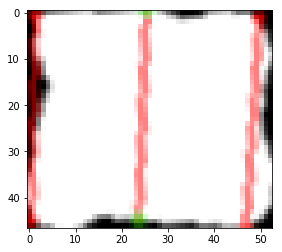

In [27]:
import os
for x in os.listdir('generated_masks'):
    try:
        find_pts('generated_masks/{}'.format(x))
    except:
        print("failed on " + x)